# Test ray tracing

Goal of this notebook is to compare the raytracing pipeline with the Born approximation. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import CMB_lensing_SBI
from CMB_lensing_SBI.healpy_utils import *
from CMB_lensing_SBI.PKDGRAV_utilities_scripts import *
from CMB_lensing_SBI.Raytracing import *
import CMB_lensing_SBI.Bornraytrace as Bornraytrace
import os
import healpy as hp
import astropy
import astropy.io.fits as fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,wCDM
from astropy.cosmology import z_at_value
import frogress
import copy
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import unyt
import yaml
from ekit import paths as path_tools
unyt.c.convert_to_units(unyt.km / unyt.s)

# short WL pipeline

In [2]:
# setup cosmology ********************
config = dict()
config['H0'] =  67.36
config['Om'] = 0.26
config['Ob'] = 0.0493
config['ns'] = 0.9649
config['s8'] = 0.84
config['nside'] = 128
cosmology = FlatLambdaCDM(H0= config['H0'] * u.km / u.s / u.Mpc, Om0=config['Om'])


k_tomo = dict()
cl_ = dict()
cl_ray = dict()
    
dictionary = np.load('../data/particles_{0}_nside_{1}.npy'.format(0,config['nside']),allow_pickle=True).item()
n_particles = dictionary['particles']
z_bin_edges = dictionary['z_edges'] 
comoving_edges = [cosmology.comoving_distance(x_) for x_ in np.array((z_bin_edges))]
un_ = comoving_edges[0].unit
comoving_edges = np.array([c.value for c in comoving_edges])
comoving_edges = comoving_edges*un_
    
# overdensity array
overdensity_array = []
for i in range(len(z_bin_edges)-1):
    overdensity_array.append(np.array(n_particles[i]/np.mean(n_particles[i])-1))
overdensity_array = np.array(overdensity_array)
    
# Initialise a raytrace object -----------------
raytrace_object = Raytracing(overdensity_array[:], cosmology, comoving_edges[:], config['nside'], NGP = False, volume_weighted = False)

#Full ray tracing
raytrace_object.raytrace_it()  
  
# Born Ray trace --------------
# new approach
kappa_lensing = np.copy(overdensity_array)*0.
for i in frogress.bar(np.arange(2,kappa_lensing.shape[0])):
    kappa_lensing[i-2] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
                         overdensity_array=overdensity_array[:(i),:].T,
                         a_centre=1./(1.+raytrace_object.redshifts[:i]), 
                         comoving_edges=comoving_edges[:(i+1)])
    
# old approach ----------------
# This is how Niall has coded. It can't be directly compared to the ray tracing one because it
# estimates lensing at the edge of the shell rather than at the center of it. Also the integration over the
# n(z) is then different.

kappa_lensing_old = np.copy(overdensity_array)*0.
for i in frogress.bar(np.arange(1,kappa_lensing.shape[0])):
    kappa_lensing_old[i-1] = Bornraytrace.raytrace(cosmology.H0, cosmology.Om0,
                         overdensity_array=overdensity_array[:(i),:].T,
                        # a_centre=1./(1.+raytrace_object.redshifts[:i]), 
                         a_centre=1./(1.+z_bin_edges[1:(i+1)]),
                         comoving_edges=comoving_edges[:(i+1)],old_approach=True)


  1.5% | [..........] | Progress: 1 / 68 | Time: 0.0s | ETA: 0.0s

/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/Raytracing.py:85: RuntimeWarning: divide by zero encountered in divide
  psi_lm = - K_lm * 2 / lrange / (lrange + 1)  # A warning may occur as the first coefficient is undefined
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/Raytracing.py:85: RuntimeWarning: invalid value encountered in divide
  psi_lm = - K_lm * 2 / lrange / (lrange + 1)  # A warning may occur as the first coefficient is undefined


  4.4% | [..........] | Progress: 3 / 68 | Time: 2.3s | ETA: 49.7s

/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/Raytracing.py:117: RuntimeWarning: invalid value encountered in divide
  cross = cross / sin


100.0% | [##########] | Progress: 68 / 68 | Time: 0.6s | ETA: --0ssss

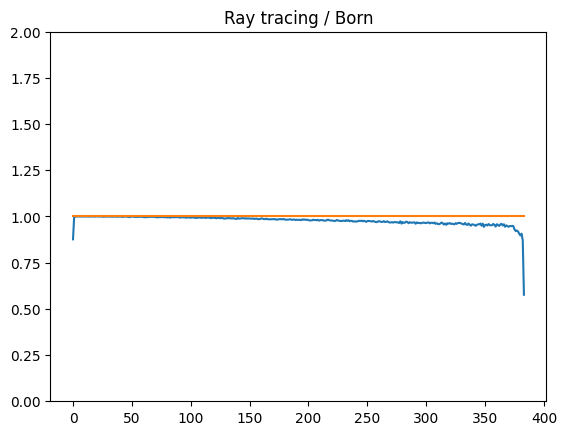

In [3]:
%matplotlib inline
i = 30

y = hp.anafast(raytrace_object.convergence_raytrace[i])/hp.anafast(kappa_lensing[i])
#y1 = hp.anafast(raytrace_object.convergence_raytrace[i])/hp.anafast(kappa_lensing_old[i]) # this doen't make much sense because it evaluates kappa at different points
plt.plot(y)
plt.plot(np.ones(len(y)))
#plt.plot(y1)
plt.ylim([0,2])
plt.title('Ray tracing / Born')
plt.show()

# n(z) integration

In [4]:
redshift_distributions_sources = np.load('../data/desy3_nz.npy',allow_pickle=True).item()
    

100.0% | [##########] | Progress: 68 / 68 | Time: 0.0s | ETA: --s

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


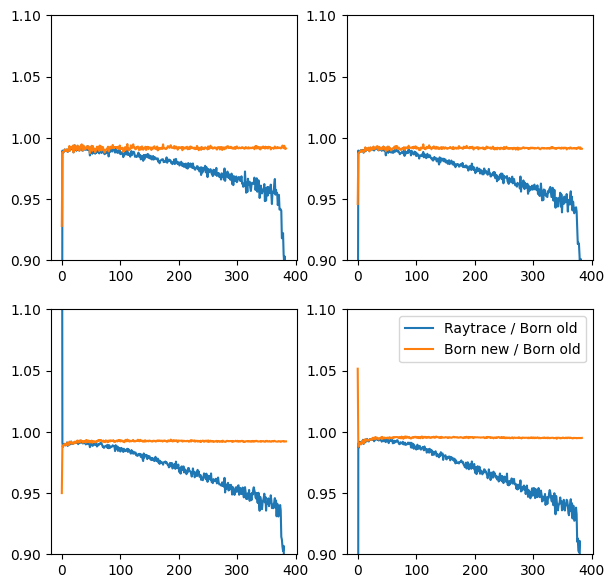

In [5]:
'''
This is the old pipeline from Niall.
'''
nz_kernel_sample_dict = dict()
for tomo_bin in [1,2,3,4]:
    k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside']))
    redshift_distributions_sources['bins'][tomo_bin][250:] = 0.
    nz_sample = Bornraytrace.recentre_nz(np.array(z_bin_edges).astype('float'),  redshift_distributions_sources['z'],  redshift_distributions_sources['bins'][tomo_bin] )
    nz_kernel_sample_dict[tomo_bin] = nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1])
    for i in frogress.bar(range(len(comoving_edges)-2)):
        k_tomo[tomo_bin]  += kappa_lensing_old[i]*nz_kernel_sample_dict[tomo_bin][i]
        
cl_old = dict()
for tomo_bin in [1,2,3,4]:
    cl_old[tomo_bin] = hp.anafast(k_tomo[tomo_bin])
    


    
'''
This is the Born approx pipeline, with the evaluation at the center of the shells.
'''
nz_kernel_sample_dict = dict()
for tomo_bin in [1,2,3,4]:
    k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside']))
    nz_sample = Bornraytrace.recentre_nz(np.array(z_bin_edges).astype('float'),  redshift_distributions_sources['z'],  redshift_distributions_sources['bins'][tomo_bin] )
    
    nz_sample = np.interp(raytrace_object.redshifts,redshift_distributions_sources['z'], redshift_distributions_sources['bins'][tomo_bin])
    nz_sample = nz_sample/np.sum(nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1]))
    nz_kernel_sample_dict[tomo_bin] = nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1])
    for i in frogress.bar(range(len(comoving_edges)-2)):
        k_tomo[tomo_bin]  += kappa_lensing[i]*nz_kernel_sample_dict[tomo_bin][i+1]
        
cl_new2 = dict()
for tomo_bin in [1,2,3,4]:
    cl_new2[tomo_bin] = hp.anafast(k_tomo[tomo_bin])
    

    
'''
This is the raytracing pipeline, with the evaluation at the center of the shells.
'''
nz_kernel_sample_dict = dict()
for tomo_bin in [1,2,3,4]:
    k_tomo[tomo_bin] = np.zeros(hp.nside2npix(config['nside']))
    nz_sample = Bornraytrace.recentre_nz(np.array(z_bin_edges).astype('float'),  redshift_distributions_sources['z'],  redshift_distributions_sources['bins'][tomo_bin] )
    
    nz_sample = np.interp(raytrace_object.redshifts,redshift_distributions_sources['z'], redshift_distributions_sources['bins'][tomo_bin])
    nz_sample = nz_sample/np.sum(nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1]))
    nz_kernel_sample_dict[tomo_bin] = nz_sample*(z_bin_edges[1:]-z_bin_edges[:-1])
    for i in frogress.bar(range(len(comoving_edges)-2)):
        k_tomo[tomo_bin]  += raytrace_object.convergence_raytrace[i]*nz_kernel_sample_dict[tomo_bin][i+1]
        
cl_new = dict()
for tomo_bin in [1,2,3,4]:
    cl_new[tomo_bin] = hp.anafast(k_tomo[tomo_bin])
    
fig, ax = plt.subplots(2,2, figsize=(7,7.))
tomo_bin = 1
for i in range(2):
    for j in range(2):

    #plt.plot(cl_new[tomo_bin]/cl_old[tomo_bin])
        ax[i,j].plot(cl_new[tomo_bin]/cl_old[tomo_bin], label ='Raytrace / Born old')
        ax[i,j].plot(cl_new2[tomo_bin]/cl_old[tomo_bin], label ='Born new / Born old')
    #plt.plot(np.ones(len(cl_new[tomo_bin]/cl_old[tomo_bin])))
        ax[i,j].set_ylim([0.9,1.1])
        tomo_bin += 1
        plt.legend()
plt.show()
    
    